In [3]:
from qiskit import *

from matplotlib import style
style.use("dark_background")

In [4]:
nqubits = 3
circuit  = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

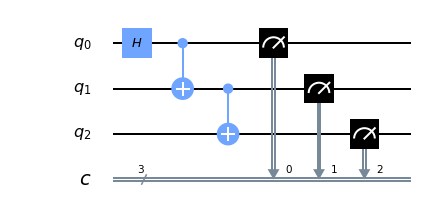

In [5]:
%matplotlib inline
circuit.draw(output = 'mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend = simulator, shots=1024).result()

In [8]:
from qiskit.visualization import plot_histogram

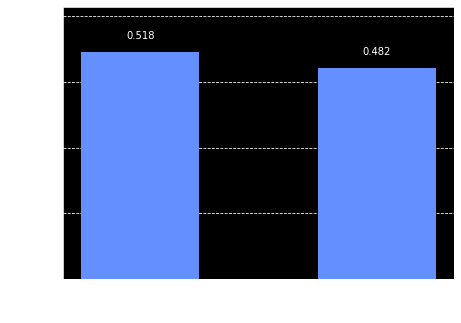

In [26]:
plot_histogram(sim_result.get_counts(circuit))

In [27]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device = provider.get_backend('ibmq_essex')

ibmqfactory.load_account:WARNING:2020-05-07 02:43:03,882: Credentials are already in use. The existing account in the session will be replaced.


In [28]:
job = execute(circuit, backend = device, shots = 1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5eb34b8d4f22fa00111d9ccd
Job Status: job has successfully run


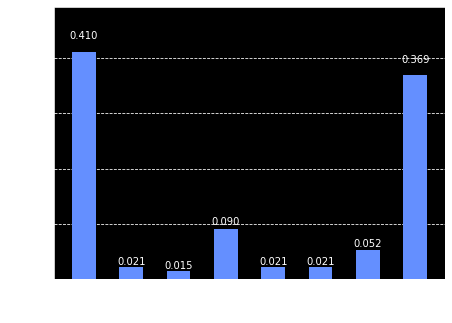

In [29]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [30]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [32]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

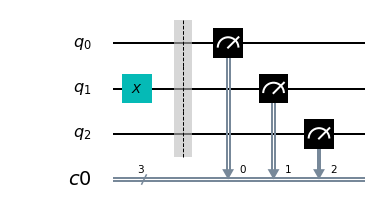

In [34]:
cal_circuits[2].draw(output = 'mpl')

In [36]:
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results= cal_job.result()

5eb34d8a4f22fa00111d9cee
Job Status: job has successfully run


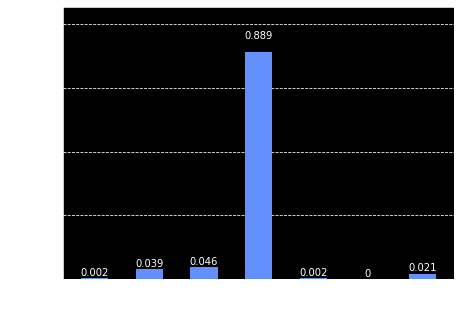

In [37]:
plot_histogram(
cal_results.get_counts(cal_circuits[3])
)

In [38]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

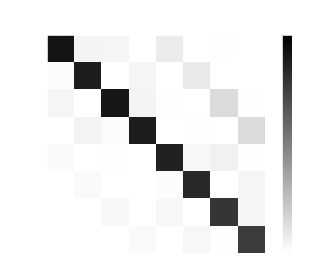

In [39]:
meas_fitter.plot_calibration()

In [40]:
meas_filter = meas_fitter.filter

In [41]:
mitigated_result = meas_filter.apply(device_result)

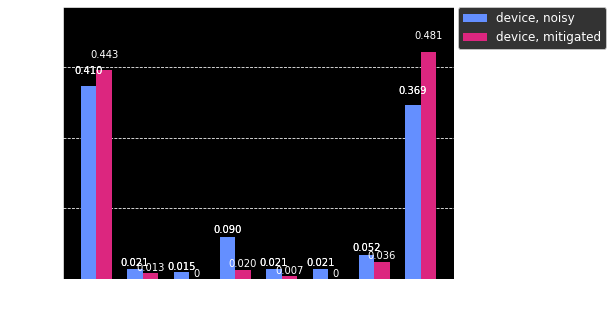

In [42]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

Another Example

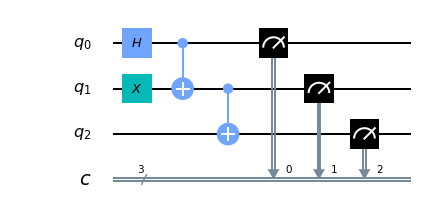

In [43]:
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2], [0,1,2])
circuit2.draw(output='mpl')

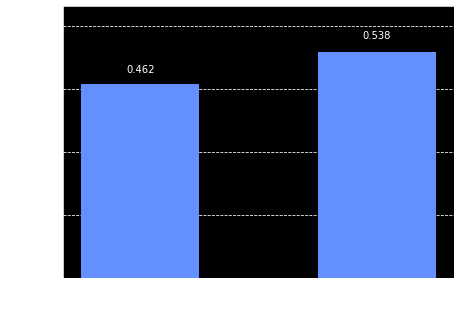

In [44]:
plot_histogram(
    execute(circuit2, backend=simulator, shots = 1024).result().get_counts(circuit2)
)

In [45]:
device_counts_2 = execute(circuit2, backend= device, shots=1024).result().get_counts(circuit2)

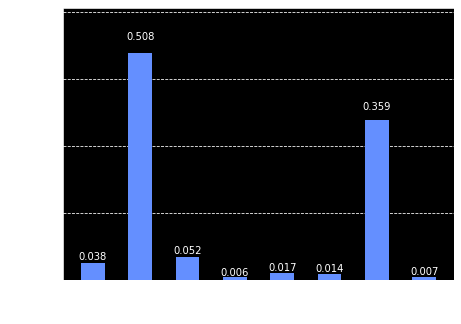

In [46]:
plot_histogram(device_counts_2)

In [47]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

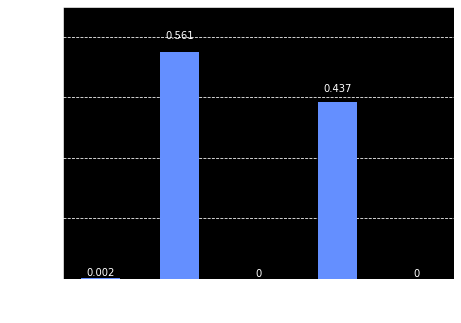

In [48]:
plot_histogram(device_mitigated_counts_2)

So in these two examples we saw how noise in quantum computers can bring us results different than the ones on the QASM Simulator (e.g. the ideal QC). With the Ignis package from Qiskit we were able to understand what those errors where, identify those faulty parameters and pass them through a fitter, and then though the fitter we generated a filter that helped us mitigate those errors.